# Machine Learning for Multibody System Dynamics

## **Session 1-1:** Introduction to Machine Learning

> We assume you know some Multibody Dynamics

Grzegorz Orzechowski and Peter Manzl

## Welcome and Context

### Workshop goals
Bridging simulation and machine learning for mechanical and mechatronic systems.

### What's ahead

- Basic ML ideas.
- Simple hands-on example.
- Surrogate modeling of hydraulic systems.
- Reinforcement learning.
- Large Language Models for modeling support.

## Why Machine Learning in MBD?

### Challenges in MBD

- High-fidelity simulations are computationally expensive.
- Real-world data is noisy, complex, and sometimes incomplete.
- ML provides rapid approximate predictions.
- Useful for:
  - Faster simulations
  - Handling nonlinearity and uncertainty
  - Real-time diagnostics and classification
  - Optimization and design exploration

### Challenges in Machine Learning

- Data.
- Models.
- Reproducibility.
- Huge literature.
- Poor quality reporting.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/AI_hierarchy.svg/480px-AI_hierarchy.svg.png)

### When to use ML in Multibody Dynamics?

- Need for speed and efficiency
- Nonlinear and complex systems
- Data-rich scenarios (sensor data, experiments)
- Optimization or design challenges
- Real-time control and monitoring

#### Examples

- Surrogate models replace complex simulations
- Classification or regression for diagnostics
- Reinforcement learning for adaptive control
- LLMs to automate or support model creation and data interpretation

Combine ML with physical models for the best results.

## What is Machine Learning?

- Algorithms that learn patterns from data.
- **Supervised learning**: learns from labeled examples.
- **Unsupervised learning**: finds patterns in unlabeled data.
- **Reinforcement learning**: learns from interactions with the environment.

### Supervised and Unsupervised Learning
![](https://upload.wikimedia.org/wikipedia/commons/4/4d/Supervised_and_unsupervised_learning.png)

### Reinforcement Learning

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Reinforcement_learning_diagram.svg/497px-Reinforcement_learning_diagram.svg.png)

## The ML workflow:
	
1.	Problem definition
2.	Data collection / generation
3.	Preprocessing
4.	Model selection and training
5.	Evaluation and testing
6.	Deployment or integration with simulation/robotics

_For MBD, we often use supervised learning to **approximate system responses**, e.g. predicting force or displacement._

## Neural Networks 

Wiki on [Neural Networks](https://en.wikipedia.org/wiki/Neural_network_(machine_learning))

A neural network consists of layers of interconnected nodes (neurons).

![Neural network architecture](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/399px-Colored_neural_network.svg.png)

- **Input Layer**: receives input data
- **Hidden Layers**: learn features from data
- **Output Layer**: provides predictions

Each node computes a weighted sum of inputs, passed through a nonlinear activation function.

### Basic structure 

- Universal approximator
- Works well when the network is large (smoothens the response)
- Typically poor extrapolation

## Neural Networks: Architectures

- **Feedforward (MLP)**: General-purpose, tabular data
- **Convolutional (CNN)**: Image and spatial/temporal data
- **Recurrent (RNN)**: Time-series and sequential data
- **Graph Neural Networks (GNN)**: Graphs, interconnected structures

Choose according to data structure.

### Autoencoders and Specialized Networks

- **Autoencoders**: Compress data into lower-dimensional representations.
  - Useful for feature extraction, anomaly detection, and noise reduction.
- **Generative Adversarial Networks (GANs)**:
  - Generate new realistic data samples.
- **Transformers**: 
  - Attention mechanisms for sequence modeling.

These specialized architectures are powerful for specific tasks.

### Gradient optimization in NNs

- Gradient descent family
- Momentum-based optimization
- Hyperparameters present in the ADAM optimizer

## ML Tools & Libraries for Engineers

- Python: scikit-learn, Keras/TensorFlow, PyTorch, pandas, matplotlib
- MATLAB also has good ML capabilities
- Platforms like Jupyter notebooks for hands-on work :)

## Challenges and Considerations

- **Data Quality and Quantity**: ML needs representative data.
- **Interpretability**: Neural networks are "black boxes."
- **Extrapolation Limits**: ML models work best within their trained data range.

Use ML carefully, complementing rather than replacing traditional models.


## Basic example: fitting noisy sine wave

### Importing packages and setting seeds for reproducibility

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

## 2. Generate Noisy Sinusoidal Dataset

We want 200 points equally spaced in [0, 2π], then add Gaussian noise (σ=0.1).
Finally, cast everything to 32-bit floats.

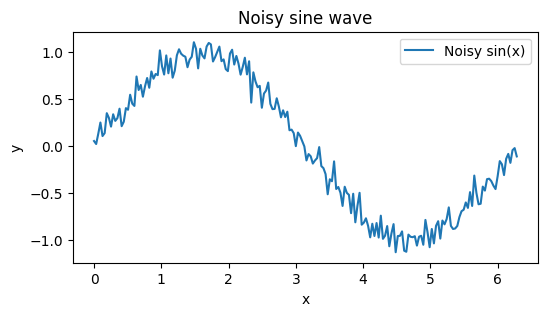

In [ ]:
# Number of total samples
N_total = 200

# Generate X_all as float32, shape (200,)
X_all = np.linspace(0, 2 * np.pi, N_total, dtype=np.float32)

# Generate noisy targets y_all = sin(x) + 0.1 * noise
y_all = np.sin(X_all).astype(np.float32) + 0.1 * np.random.randn(N_total).astype(np.float32)

# (Optional) Visualize the noisy sine:
plt.figure(figsize=(6, 3))
plt.plot(X_all, y_all, label="Noisy sin(x)")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Noisy sine wave")
plt.show()

## 3. Split into Training (75%) and Validation (25%)

In [ ]:
# Compute the index at which to split
n_train = int(round(0.75 * N_total))   # = 150

# Split in NumPy, then convert to PyTorch tensors
X_train_np = X_all[:n_train].reshape(-1, 1)   # shape: (150, 1)
y_train_np = y_all[:n_train].reshape(-1, 1)   # shape: (150, 1)

X_val_np = X_all[n_train:].reshape(-1, 1)     # shape: (50, 1)
y_val_np = y_all[n_train:].reshape(-1, 1)     # shape: (50, 1)

# Convert to torch.FloatTensor
X_train = torch.from_numpy(X_train_np)    # dtype=torch.float32, shape (150, 1)
y_train = torch.from_numpy(y_train_np)    # shape (150, 1)

X_val = torch.from_numpy(X_val_np)        # shape (50, 1)
y_val = torch.from_numpy(y_val_np)        # shape (50, 1)

## 4. Define the Model, Loss, and Optimizer

In PyTorch, we use `nn.Sequential`.

In [ ]:
model = nn.Sequential(
    nn.Linear(1, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

# Move model to CPU (default). If you have GPU, you could .to('cuda'), but not required here.

# Mean Squared Error loss
criterion = nn.MSELoss()

# Adam optimizer with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5. Training Loop (1000 Epochs)

We will record train‐loss and val‐loss at each epoch into NumPy arrays (float32).

In [ ]:
epochs = 1000
train_loss_history = np.zeros(epochs, dtype=np.float32)
val_loss_history = np.zeros(epochs, dtype=np.float32)

for epoch in range(epochs):
    # --- Training Step ---
    model.train()
    optimizer.zero_grad()
    
    # Forward pass on entire training set
    outputs = model(X_train)           # shape: (150, 1)
    loss_train = criterion(outputs, y_train)
    
    # Backward + optimize
    loss_train.backward()
    optimizer.step()
    
    # Save the training loss (detach → scalar → float)
    train_loss_history[epoch] = loss_train.item()
    
    # --- Validation Step (no grad) ---
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        loss_val = criterion(val_preds, y_val)
        val_loss_history[epoch] = loss_val.item()

## 6. Plot Training vs. Validation Loss

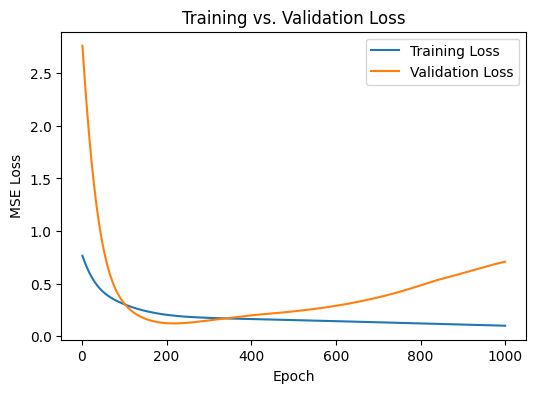

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, epochs + 1), train_loss_history, label="Training Loss")
plt.plot(np.arange(1, epochs + 1), val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

## 7. Plot Model Predictions vs. True Data

Compute the model’s predictions on both train and validation sets.

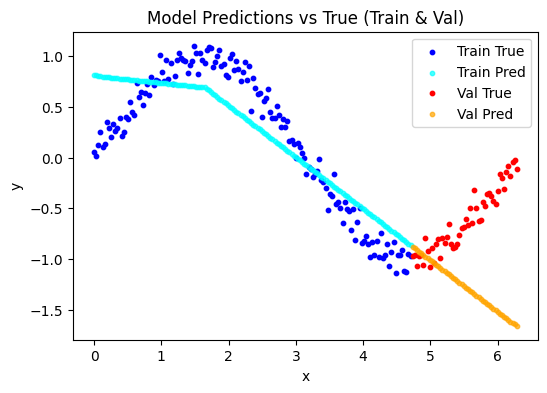

In [ ]:
model.eval()
with torch.no_grad():
    pred_train = model(X_train).cpu().numpy().reshape(-1,)   # shape → (150,)
    pred_val   = model(X_val).cpu().numpy().reshape(-1,)     # shape → (50,)

# Convert X back to 1D arrays for plotting
X_train_plot = X_train.numpy().reshape(-1,)
X_val_plot   = X_val.numpy().reshape(-1,)

y_train_plot = y_train.numpy().reshape(-1,)
y_val_plot   = y_val.numpy().reshape(-1,)

# Plot predictions and true points
plt.figure(figsize=(6, 4))
plt.scatter(X_train_plot, y_train_plot, color="blue", s=10, label="Train True")
plt.scatter(X_train_plot, pred_train, color="cyan", s=10, label="Train Pred", alpha=0.7)

plt.scatter(X_val_plot, y_val_plot, color="red", s=10, label="Val True")
plt.scatter(X_val_plot, pred_val, color="orange", s=10, label="Val Pred", alpha=0.7)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Model Predictions vs True (Train & Val)")
plt.legend()
plt.show()

## Next Examples

### 1-2: Linear Oscillator

- Provides interesting insight into neural networks
	
### 2: Supervised Learning -- Nonlinear Mass-Spring-Damper System

- Generate synthetic data with varying stiffness, damping, and input force
- Fit a regression model to predict system response at certain time steps
- Present simple classifier
	
### 3: Reinforcement Learning

- Introduction to environments, agents, and their interaction
- Training RL controllers on cart poles

### 4: Large Language Models for Model Generation

- Introduction to LLMs -- online and offline uses
- Generating simulation code for an oscillator
- Generating meaningful multibody models